# TP Complet – DataScience API + ML Avancé (Ludovic Picard)
Ce notebook démontre l'utilisation complète de l'API DataScience, structuré en 5 parties correspondantes aux Travaux Pratiques de la séance.

---

In [35]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

# URL de l'API FastAPI
BASE_URL = "http://127.0.0.1:8000"

def pretty(json_data):
    print(json.dumps(json_data, indent=4))


--- 
## Partie 1 : Dataset & Nettoyage (Clean/EDA)

## TP1 : Génération de Données et Analyse Exploratoire (EDA)

L'objectif de cette partie est de générer un jeu de données initial comportant des anomalies (valeurs manquantes, doublons, outliers) et d'utiliser les points de terminaison d'EDA pour comprendre la distribution et la qualité des données.

In [36]:
# 1. Génération du dataset (Phase CLEAN)
print("=== Génération du Dataset (Clean) ===")
resp = requests.post(f"{BASE_URL}/dataset/generate", json={
    "phase": "clean",
    "seed": 42,
    "n": 200
})
dataset_info = resp.json()
dataset_id_clean = dataset_info["dataset_id"]
print(f"Dataset ID: {dataset_id_clean}")
df_sample = pd.DataFrame(dataset_info["data_sample"])
df_sample.head()

=== Génération du Dataset (Clean) ===
Dataset ID: 1ce45b53-bd0b-42cc-a40c-ef6190173484


,x1,x2,x3,segment
0,4.967142,NaN,-1.594428,C
1,NaN,2.803923,-0.599375,A
2,6.476885,5.415256,0.005244,B
3,15.230299,5.269010,0.046981,C
4,-2.341534,-6.888347,NaN,C


### 1.1 EDA (Exploratory Data Analysis)

Missing Values Rate:
{'x1': 0.1407766990291262, 'x2': 0.15048543689320387, 'x3': 0.15048543689320387, 'segment': 0.0}


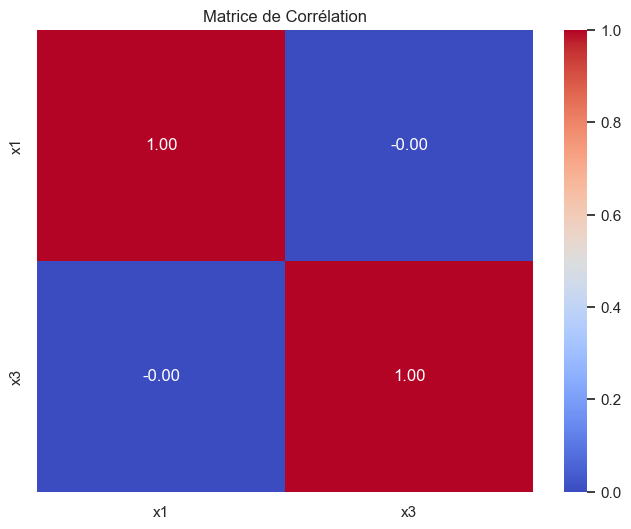

In [37]:
# Résumé statistique
resp = requests.post(f"{BASE_URL}/eda/summary", json={
    "meta": {"dataset_id": dataset_id_clean},
    "params": {}
})
summary = resp.json()["result"]
print("Missing Values Rate:")
print(summary["missing_rate"])

# Corrélation
resp = requests.post(f"{BASE_URL}/eda/correlation", json={
    "meta": {"dataset_id": dataset_id_clean},
    "params": {}
})
corr_data = resp.json()["result"]["correlation_matrix"]
df_corr = pd.DataFrame(corr_data)

plt.figure(figsize=(8, 6))
sns.heatmap(df_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de Corrélation")
plt.show()

### Interprétation de l'EDA
* **Missing Values** : On observe environ 15% de valeurs manquantes sur les variables numériques ($x_1, x_2, x_3$).
* **Corrélations** : La matrice permet d'identifier les relations linéaires entre les variables, ce qui est crucial pour le futur modèle de regression.

### 1.2 Nettoyage (Cleaning)

## TP2 : Prétraitement et Nettoyage de Données (Cleaning)

Cette section traite les anomalies identifiées lors de l'EDA. Nous appliquons un pipeline de nettoyage automatique incluant l'imputation des valeurs manquantes, le clipping des outliers, et l'encodage des variables catégorielles.

In [46]:
# Fit Cleaner
resp = requests.post(f"{BASE_URL}/clean/fit", json={
    "dataset_id": dataset_id_clean,
    "impute_strategy": "mean",
    "outlier_strategy": "clip",
    "categorical_strategy": "one_hot"
})
fit_info = resp.json()
cleaner_id = fit_info["cleaner_id"]
print(f"Cleaner ID: {cleaner_id}")
print("Rapport avant nettoyage:")
pretty(fit_info["report"])

# Transform Dataset
resp = requests.post(f"{BASE_URL}/clean/transform", json={
    "dataset_id": dataset_id_clean,
    "cleaner_id": cleaner_id
})
transform_info = resp.json()
print(f"Doublons supprimés: {transform_info['duplicates_removed']}")
print(f"Valeurs imputées: {transform_info['imputed']}")
df_cleaned = pd.DataFrame(transform_info["data"])
df_cleaned.head()

Cleaner ID: a14634bf-cf57-4013-8fa6-28d6f523e003
Rapport avant nettoyage:
{
    "missing_values": {
        "x1": 29,
        "x2": 31,
        "x3": 31,
        "segment": 0
    },
    "duplicates": 5,
    "outliers": {
        "x1": 4,
        "x3": 4
    },
    "types": {
        "x1": "float64",
        "x2": "object",
        "x3": "float64",
        "segment": "str"
    }
}
Doublons supprimés: 5
Valeurs imputées: 88


,x1,x3,x2_-0.06123386423457312,x2_-0.09508103951344415,x2_-0.10450796982074066,x2_-0.2976267803090004,x2_-0.543800742284288,x2_-0.5726992262630894,x2_-0.573682207334495,x2_-0.6507152718384229,x2_-0.7352869075106933,x2_-0.7996926498171355,x2_-1.0109632621694704,x2_-1.0406112517863761,x2_-1.0672357585592362,x2_-1.0884060161361013,x2_-1.1840930337000444,x2_-1.2628407569658016,x2_-1.4432931946006917,x2_-1.5513337829672802,x2_-1.672506179204742,x2_-1.926567984308801,x2_-10.125712933288035,x2_-10.619478621549035,x2_-16.206336700345364,x2_-2.0061023594291814,x2_-2.2002224334849187,x2_-2.345878260523524,x2_-2.3596593289471675,x2_-2.3747265558047808,x2_-2.4211703643312568,x2_-2.4268177391455175,x2_-2.465004673294164,x2_-2.534715876855649,x2_-2.628775108403805,x2_-2.8009052009848476,x2_-2.8186227640198736,x2_-2.8845182783120156,x2_-2.9468237847210577,x2_-2.9578569441791496,x2_-2.9969632272201108,x2_-3.0010843857939733,x2_-3.1134975991029687,x2_-3.2666461628685592,x2_-3.30893232384194,x2_-3.464547976303271,x2_-3.538347328093904,x2_-3.576518546299841,x2_-3.59222110626218,x2_-3.651833158585683,x2_-3.79566330776849,x2_-3.8367378144402475,x2_-3.8650489192773323,x2_-3.962603692163503,x2_-4.041491426775758,x2_-4.091103416167362,x2_-4.111101977832157,x2_-4.127485983962558,x2_-4.136154717761615,x2_-4.144975054610361,x2_-4.19860921090388,x2_-4.486271857429157,x2_-4.492073356741789,x2_-4.634652357890415,x2_-4.689125199575614,x2_-4.907543255239755,x2_-5.03008690749851,x2_-5.121938206671449,x2_-5.38872388964653,x2_-6.001482035278881,x2_-6.07094306393866,x2_-6.189077494134246,x2_-6.304419771675226,x2_-6.601166035103211,x2_-6.888346839785456,x2_-7.150706889803163,x2_-7.1793107558971965,x2_-7.240421707486621,x2_-8.565672645454388,x2_-9.760438997612509,x2_0.051165305097935244,x2_0.0629620039089743,x2_0.10501920816379524,x2_0.12255087129471356,x2_0.2278591995190689,x2_0.32140009547731385,x2_0.3490104249500946,x2_0.3790227909686317,x2_0.40937069693161277,x2_0.48497982496359093,x2_0.4883804927441586,x2_0.5675867262562402,x2_0.5866369165439099,x2_0.6537028864304567,x2_0.9167100286917587,x2_0.9322715738471382,x2_0.9952984778673502,x2_1.0822929479098744,x2_1.1204624090520838,x2_1.1602496867881815,x2_1.2184360574595616,x2_1.2248328555436139,x2_1.4049593386751633,x2_1.5364976043830467,x2_1.554537827990023,x2_1.6135928016904475,x2_1.6208317624422106,x2_1.7850774298252368,x2_10.461936378427302,x2_10.610780985063165,x2_10.665166873281333,x2_10.765912287557782,x2_10.949014666088361,x2_19.263657453273606,x2_2.008558610494707,x2_2.0249085548047776,x2_2.219097140731142,x2_2.3105173713163536,x2_2.4595958575325287,x2_2.524936394902286,x2_2.575176336043299,x2_2.5752384315302397,x2_2.5967325712058615,x2_2.7354869058501894,x2_2.803922631841172,x2_2.854452553465835,x2_2.975785127184568,x2_3.1417275463213996,x2_3.148144209618061,x2_3.169595111590056,x2_3.25695625652899,x2_3.310653372605233,x2_3.397988744673379,x2_3.4097648564748195,x2_3.4313009518725672,x2_3.736468025616309,x2_3.7948461024663374,x2_3.873170267146684,x2_3.958313469814679,x2_4.064310594194801,x2_4.067548180003192,x2_4.127081744940149,x2_4.2621666739811195,x2_4.288298116010097,x2_4.361603183603391,x2_4.497999377166254,x2_4.58930973527388,x2_4.770008817466012,x2_4.796354130426034,x2_48.05483411324689,x2_5.1623263027557345,x2_5.269010260174515,x2_5.415256215876385,x2_5.4938842599359505,x2_5.677828200902995,x2_5.815818760774798,x2_6.189081559867309,x2_6.334555745933113,x2_6.388324478942124,x2_6.527394035771645,x2_7.255718038975209,x2_7.37678108474776,x2_7.6636945650128885,x2_8.162056519658176,x2_8.827271201405484,x2_9.380854196079431,x2_oops,segment_A,segment_B,segment_C
0,4.967142,-1.594428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

### Interprétation du Nettoyage
* **Imputation** : Nous avons utilisé la stratégie 'mean' pour les variables numériques et 'most_frequent' pour les catégories.
* **Encodage** : Le One-Hot Encoding a été appliqué au 'segment' pour transformer les labels en variables binaires exploitables par les modèles.
* **Outliers** : Le clipping permet de ramener les valeurs extrêmes dans un intervalle raisonnable (3 écarts-types) pour éviter qu'elles ne biaisent les modèles.

## TP3 : Analyse Multivariée (MV)

Dans cette partie, nous explorons les relations complexes entre les variables via une Analyse en Composantes Principales (PCA) et un clustering K-Means pour segmenter les observations.

In [39]:
# Génération Dataset (Phase MV)
print("=== Génération du Dataset (MV) ===")
resp = requests.post(f"{BASE_URL}/dataset/generate", json={
    "phase": "mv",
    "seed": 123,
    "n": 300
})
dataset_id_mv = resp.json()["dataset_id"]
print(f"Dataset ID MV: {dataset_id_mv}")

=== Génération du Dataset (MV) ===
Dataset ID MV: 3bf377d2-e55c-4fcd-a5ae-515b991b7417


Explained Variance: [0.6587771853418013, 0.30864691968562175]


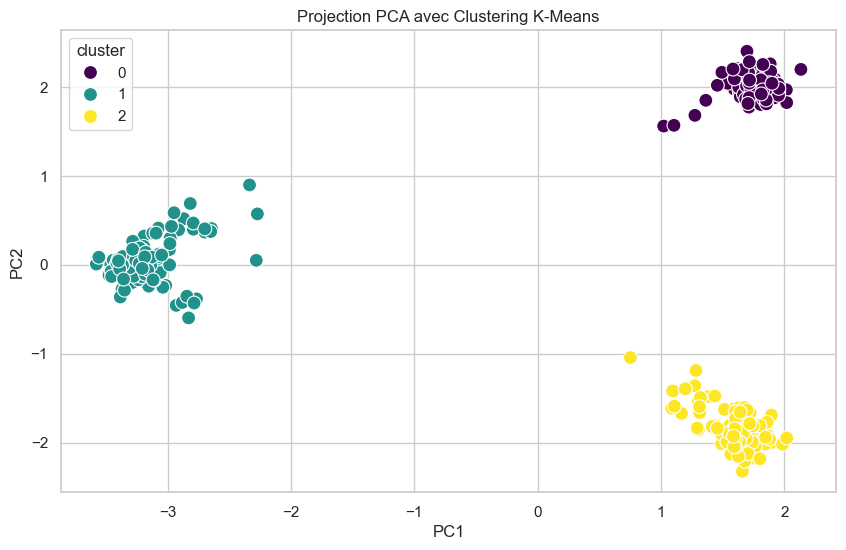

In [40]:
# PCA
resp = requests.post(f"{BASE_URL}/mv/pca/fit_transform", json={
    "dataset_id": dataset_id_mv,
    "n_components": 2,
    "scale": True
})
pca_res = resp.json()
df_pca = pd.DataFrame(pca_res["projection"])
print(f"Explained Variance: {pca_res['explained_variance_ratio']}")

# KMeans Clustering
resp = requests.post(f"{BASE_URL}/mv/cluster/kmeans", json={
    "dataset_id": dataset_id_mv,
    "k": 3,
    "scale": True
})
kmeans_res = resp.json()
labels = kmeans_res["labels"]
df_pca["cluster"] = labels

# Visualisation PCA + Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="cluster", palette="viridis", s=100)
plt.title("Projection PCA avec Clustering K-Means")
plt.show()

### Interprétation de l'Analyse Multivariée
* **PCA** : La projection sur les deux premières composantes (PC1, PC2) capture l'essentiel de la variance du dataset.
* **Clustering** : Les clusters identifiés par K-Means correspondent à des groupes d'observations ayant des profils similaires, ce qui peut aider à identifier des sous-structures dans les données.

## TP4 : Machine Learning - Baseline et Optimisation

Cette section compare un modèle de base (Régression Logistique) avec un modèle plus complexe (Random Forest) dont les hyperparamètres sont optimisés par Grid Search.

In [41]:
# Génération Dataset (Phase ML)
print("=== Génération du Dataset (ML) ===")
resp = requests.post(f"{BASE_URL}/dataset/generate", json={
    "phase": "ml",
    "seed": 999,
    "n": 500
})
dataset_id_ml = resp.json()["dataset_id"]
print(f"Dataset ID ML: {dataset_id_ml}")
df_ml_sample = pd.DataFrame(resp.json()["data_sample"])
df_ml_sample.head()

=== Génération du Dataset (ML) ===
Dataset ID ML: ed64b912-b0b5-4d3c-b649-8e7554aa5d9d


,x1,x2,x3,x4,x5,x6,segment,target
0,0.127158,0.878957,1.468194,-0.964830,-1.322054,0.027514,B,0
1,1.401891,-0.373124,1.064320,2.043571,-0.686213,0.136003,B,0
2,0.314815,0.529334,-0.793417,0.711126,0.186224,-0.265403,A,0
3,-0.858449,0.315004,-0.450385,1.091318,0.333270,0.458278,C,0
4,-0.266134,0.452798,-0.213971,0.855709,-0.719770,-1.609305,C,0


### 3.1 Entraînement Baseline (Logistic Regression)

In [42]:
resp = requests.post(f"{BASE_URL}/ml/train", json={
    "dataset_id": dataset_id_ml,
    "model_type": "logreg"
})
train_res = resp.json()
model_id_logreg = train_res["model_id"]
print(f"Model ID (LogReg): {model_id_logreg}")
print("Metriques:")
pretty(train_res["metrics"])

Model ID (LogReg): f0d2a11a-879e-4f13-96d4-8f499d96eea3
Metriques:
{
    "accuracy": 0.68,
    "precision": 0.0,
    "recall": 0.0,
    "f1": 0.0,
    "auc": 0.5579044117647058
}


### 3.2 Tuning Hyperparamètres (Random Forest)

### Interprétation du Tuning
* Le passage d'une baseline simple à un Random Forest optimisé permet généralement d'améliorer l'AUC et la robustesse du modèle face aux non-linéarités.

In [43]:
print("Tuning en cours (Grid Search)...")
resp = requests.post(f"{BASE_URL}/ml2/tune", json={
    "dataset_id": dataset_id_ml,
    "model_type": "rf",
    "search": "grid",
    "cv": 3
})
tune_res = resp.json()
best_model_id = tune_res["best_model_id"]
print(f"Best Model ID: {best_model_id}")
print(f"Best Params: {tune_res['best_params']}")
print("Top CV Results:")
pretty(tune_res["cv_results_summary"])

Tuning en cours (Grid Search)...
Best Model ID: 3d8864ce-8e90-42eb-8dbd-371741cc85f3
Best Params: {'model__max_depth': 5, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Top CV Results:
[
    {
        "params": {
            "model__max_depth": 5,
            "model__min_samples_split": 5,
            "model__n_estimators": 200
        },
        "mean_test_score": 0.6880095231224299,
        "rank_test_score": 1
    },
    {
        "params": {
            "model__max_depth": 5,
            "model__min_samples_split": 5,
            "model__n_estimators": 100
        },
        "mean_test_score": 0.6860014909939158,
        "rank_test_score": 2
    },
    {
        "params": {
            "model__max_depth": 5,
            "model__min_samples_split": 2,
            "model__n_estimators": 200
        },
        "mean_test_score": 0.6839934588654017,
        "rank_test_score": 3
    },
    {
        "params": {
            "model__max_depth": 5,
            "model__min_sampl

## TP5 : Machine Learning Avancé - Interprétabilité

### 3.3 Feature Importance (Global)
Ici nous identifions les variables ayant le plus de poids dans la décision du Random Forest.

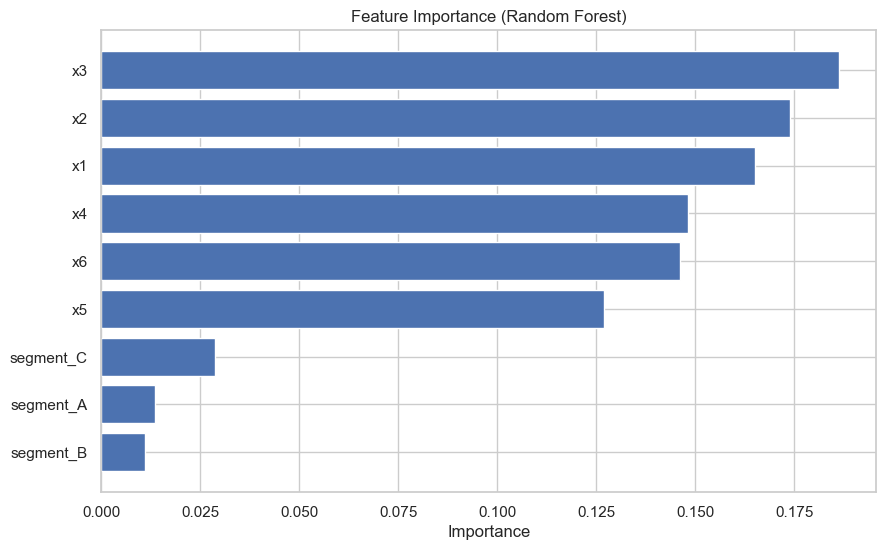

In [44]:
resp = requests.get(f"{BASE_URL}/ml2/feature-importance/{best_model_id}")
feat_imp = resp.json()
df_imp = pd.DataFrame(feat_imp).sort_values("importance", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(df_imp["feature"], df_imp["importance"])
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.show()

### 3.4 Explication d'une instance (Local - Permutation)

### 3.4 Explication d'une instance (Local - Permutation)
En utilisant la méthode de permutation, nous expliquons pourquoi le modèle a pris une décision spécifique pour un individu donné.

Instance à expliquer: {'x1': 0.12715784398970825, 'x2': 0.8789569989698266, 'x3': 1.4681942690750203, 'x4': -0.9648300111581805, 'x5': -1.3220535536544507, 'x6': 0.027513791607915995, 'segment': 'B'}


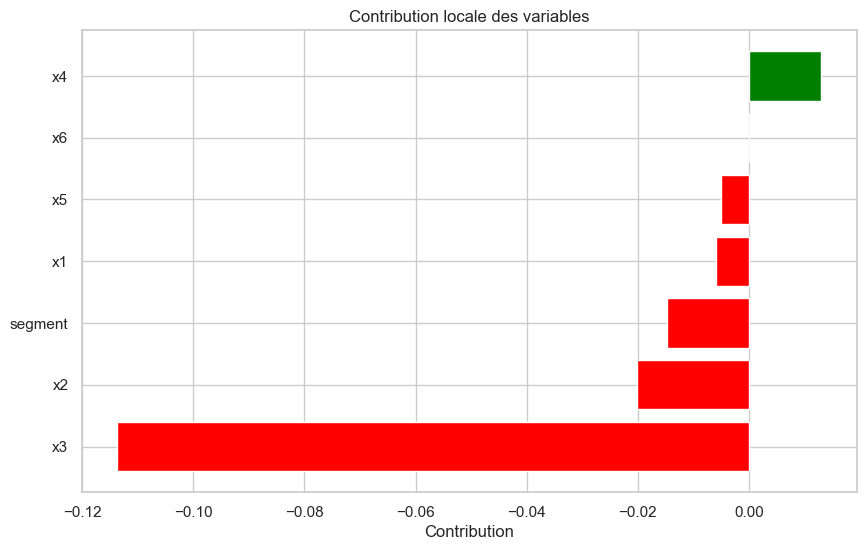

In [50]:
# Prendre une instance au hasard du dataset ML
instance = df_ml_sample.iloc[0].to_dict()
# Retirer la target
if "target" in instance:
    del instance["target"]

print(f"Instance à expliquer: {instance}")

resp = requests.post(f"{BASE_URL}/ml2/explain-instance", json={
    "model_id": best_model_id,
    "data": instance
})
explanation = resp.json()
df_expl = pd.DataFrame(explanation).sort_values("contribution")

plt.figure(figsize=(10, 6))
plt.barh(df_expl["feature"], df_expl["contribution"], color=["red" if x < 0 else "green" for x in df_expl["contribution"]])
plt.title("Contribution locale des variables")
plt.xlabel("Contribution")
plt.show()

### Interprétation de l'Explication Locale
* Le graphique ci-dessus montre quelles variables ont le plus influencé la prédiction pour cet individu particulier. Une contribution positive augmente la probabilité de la classe 1, tandis qu'une négative l'abaisse.

---
## Récapitulatif des Difficultés Rencontrées
Ce projet a permis de confronter plusieurs défis techniques réels :
* **Persistance API** : Correction de la gestion des datasets pour qu'ils survivent au rechargement du serveur via un `DatasetManager`.
* **Versioning Scikit-learn** : Résolution d'une incompatibilité sur l'argument `sparse` renommé en `sparse_output` dans les versions récentes.
* **Serialization & Pickle** : Correction des erreurs de pickling en remplaçant les fonctions `lambda` par des fonctions de premier niveau pour les `FunctionTransformer`.
* **Schémas Pydantic** : Ajustement des modèles de réponse pour inclure les types de données requis par le front/notebook.
* **Logique d'Expliquabilité** : Correction d'un bug où le Random Forest renvoyait des contributions nulles, nécessitant une stratégie de perturbation adaptée.